# PoseNet

[PoseNet: A Convolutional Network for Real-Time 6-DOF Camera Relocalization](https://arxiv.org/pdf/1505.07427.pdf)

## Necessary libraries

In [0]:
import os
import torch
import torchvision
import numpy as np
import copy
import torchsummary
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import colors, pyplot as plt
from time import gmtime, strftime
from torchvision.models import googlenet
from tqdm import tqdm, tqdm_notebook
from operator import itemgetter

In [0]:
# If you want deterministic, just uncomment the lines below.

'''
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
'''

'\nnp.random.seed(0)\ntorch.manual_seed(0)\ntorch.cuda.manual_seed(0)\ntorch.backends.cudnn.deterministic = True\n'


## Global variables

In [0]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
RESCALE_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
WORK_DIR = ''
PATH_DATA = WORK_DIR + '/data'

print('You are working on ' + str(DEVICE))

You are working on cuda:0


In [0]:
# If you are using google colab, uncomment the lines below.

from google.colab import drive
drive.mount('/content/drive/')

WORK_DIR = '/content/drive/My Drive/Colab Notebooks/Projects/pose-net'
PATH_DATA = WORK_DIR + '/data'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Upload data

In [0]:
info = pd.read_csv(PATH_DATA + '/info.csv')
info.head()

,Unnamed: 0,Unnamed: 0.1,TimeStamp,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,IMU_LAX,IMU_LAY,IMU_LAZ,IMU_AVX,IMU_AVY,IMU_AVZ,ImageFile,DepthFile,SegFile
0,0,0,1542098918672,1.628652,-1.342870,-0.038781,1.000000,-0.0,0.0,0.000000,-0.012323,0.012355,-9.793530,0.000031,0.000238,0.000235,img_0_0_1542098919031247900.png,img_0_3_1542098919034924900.png,img_0_5_1542098919037481300.png
1,1,1,1542098927672,0.539220,-0.753961,-0.038781,0.219876,-0.0,0.0,0.975528,-0.004269,-0.007061,-9.796641,-0.000113,0.000299,0.000157,img_0_0_1542098928056216200.png,img_0_3_1542098928058906700.png,img_0_5_1542098928061151600.png
2,2,2,1542099006672,1.811826,-1.783541,-0.038781,0.845706,-0.0,0.0,0.533649,0.007127,-0.006138,-9.802512,0.000018,0.000242,-2.073797,img_0_0_1542099007064132600.png,img_0_3_1542099007066469000.png,img_0_5_1542099007068223000.png
3,3,3,1542099035673,1.735275,0.055900,-0.038781,0.988930,-0.0,0.0,0.148384,4.352539,3.855151,-9.808618,-0.000499,-0.000436,-1.609914,img_0_0_1542099036029939100.png,img_0_3_1542099036032202400.png,img_0_5_1542099036034012000.png
4,4,4,1542099047673,-1.467342,-0.783857,-0.038781,0.127870,0.0,-0.0,-0.991791,0.001481,-0.007924,-9.816813,0.000579,0.000273,-0.000102,img_0_0_1542099048061266300.png,img_0_3_1542099048063828800.png,img_0_5_1542099048066488000.png


In [0]:
DATA_MODES = ['train', 'test']


class RelocalizationDataset(Dataset):

    def __init__(self, info, path_data, transform=None,
                 loader=torchvision.datasets.folder.default_loader,
                 mode='train'):
        super().__init__()

        self.info = info
        self.path_data = path_data
        self.transform = transform
        self.loader = loader
        self._len = info.shape[0]
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

    def __getitem__(self, index):
        images = []

        for name in [-3, -2, -1]:
            images.append(self.loader(os.path.join(self.path_data, self.info[index][name])))

            if self.transform is not None:
                images[-1] = self.transform(images[-1])

        if self.mode == 'train':
            return (torch.Tensor([np.array(image) for image in images]),
                    torch.Tensor(np.array(self.info[index][3:10], dtype=np.float16)))
        else:
            return torch.Tensor([np.array(image) for image in images])

    def __len__(self):
        return self._len

In [0]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.RandomCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(MEAN, STD)])

X_train, X_test = train_test_split(info.values, test_size = 0.2, random_state = 123)

image_datasets = {
    'train': RelocalizationDataset(
        X_train, PATH_DATA + '/images', transform=transform),
    'val': RelocalizationDataset(
        X_test, PATH_DATA + '/images', transform=transform)
}

data_loaders = {
  x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 10, 
                                 shuffle = True)
    for x in ['train', 'val']
}

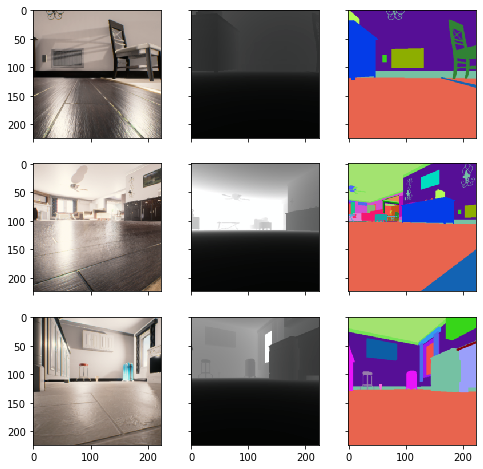

In [63]:
def imshow(tensor_image, ploter = plt, title = None):
    image = tensor_image.numpy().transpose((1, 2, 0))
    image = np.array(STD) * image + np.array(MEAN)
    image = np.clip(image, 0, 1)

    ploter.imshow(image)

    if title is not None:
        ploter.set_title(title)
    ploter.grid(False)


fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey = True, sharex = True)

i = 0
for fig_x in ax.flatten():
    if i % 3 == 0:
        random_character = int(np.random.uniform(0, 500))
    images, label = image_datasets['train'][random_character]

    imshow(images[i % 3].data.cpu(), ploter = fig_x)
    i += 1

## PoseNet model

In [0]:
class PoseNet(nn.Module):
    __out_classes__ = 7

    def __init__(self):
        super(PoseNet, self).__init__()

        self.base_model = googlenet(pretrained=True, aux_logits=True)
        self.base_model.aux1.fc2 = nn.Linear(1024, self.__out_classes__)
        self.base_model.aux2.fc2 = nn.Linear(1024, self.__out_classes__)
        self.base_model.fc = nn.Linear(1024, self.__out_classes__)
    
    def forward(self, x):
        return self.base_model._forward(x)

### Common functions

In [0]:
def save_weights(model, model_name, val_acc):
    name = strftime("%Yy.%mm.%dd.%Hh.%Mm", gmtime())
    model_weights = copy.deepcopy(model.state_dict())
    torch.save(model_weights, \
               f"{WORK_DIR}/weights/{model_name}/{round(val_acc, 3)}___{name}.pth")

def load_weights(model, model_name, weights_name):
    model.load_state_dict(torch.load(f"{WORK_DIR}/weights/{model_name}/{weights_name}"))
    model.eval()

### Train

In [0]:
def loss(y, y_pred):
    return torch.norm(y[:3] - y_pred[:3]) + 157 * torch.norm(y[3:] - y_pred[3:] / torch.norm(y_pred[3:] ))

In [0]:
def fit_epoch(model, data_loader, loss_fn, optimizer):
    model.train(True)

    running_loss = 0.0
    processed_data = 0
  
    for batch, labels in data_loader:
        batch = batch.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        
        prediction_x, prediction_aux1, prediction_aux2 = [sum(model(batch[:, i].to(DEVICE))[j] for i in range(3)) / 3 for j in range(3)]
        loss_x = loss_fn(prediction_x, labels)
        loss_aux1 = loss_fn(prediction_aux1, labels)
        loss_aux2 = loss_fn(prediction_aux2, labels)

        loss_x.backward()
        loss_aux1.backward()
        loss_aux2.backward()
        optimizer.step()

        running_loss += loss_x.item() * batch.size(0)
        processed_data += batch.size(0)
        
    train_loss = running_loss / processed_data

    return train_loss

In [0]:
def eval_epoch(model, data_loader, loss_fn):
    model.eval()

    running_loss = 0.0
    processed_size = 0

    for batch, labels in data_loader:
        batch = batch.to(DEVICE)
        labels = labels.to(DEVICE)
        

        with torch.set_grad_enabled(False):
            prediction_x = sum(model(batch[:, i].to(DEVICE))[0] for i in range(3)) / 3
            loss_x = loss_fn(prediction_x, labels)

        running_loss += loss_x.item() * batch.size(0)
        processed_size += batch.size(0)

    loss = running_loss / processed_size

    return loss

In [0]:
def train(data_loader, model, epochs, model_name, save = False):
    history = []
    log_template = "\nLog epoch {ep:03d}:\n\ttrain_loss: {t_loss:0.4f} \n\tval_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total = epochs) as pbar_outer:
        optimizer = torch.optim.Adam(model.parameters())
        loss_fn = loss
        
        for epoch in range(epochs):
            train_loss = fit_epoch(model, data_loader['train'], 
                                              loss_fn, optimizer)
            val_loss = eval_epoch(model, data_loader['val'], loss_fn)

            history.append((train_loss, val_loss))
            tqdm.write(log_template.format(ep = epoch + 1, t_loss = train_loss, 
                                           v_loss = val_loss))
            pbar_outer.update(1)

            if save:
                save_weights(model, model_name, val_loss)
            
    return history

In [99]:
model = PoseNet().to(DEVICE)

load_weights(model, 'PoseNet', weights_name='97.667___2020y.02m.16d.20h.26m.pth')

history = train(data_loaders, model = model, epochs = 7, model_name='PoseNet', save = True)

/usr/local/lib/python3.6/dist-packages/torchvision/models/googlenet.py:46: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn('auxiliary heads in the pretrained googlenet model are NOT pretrained, '
epoch:  14%|█▍        | 1/7 [01:56<11:41, 116.87s/it]


Log epoch 001:
	train_loss: 93.0447 
	val_loss 110.4610


epoch:  29%|██▊       | 2/7 [03:52<09:42, 116.48s/it]


Log epoch 002:
	train_loss: 77.9334 
	val_loss 111.8466


epoch:  43%|████▎     | 3/7 [05:50<07:47, 116.83s/it]


Log epoch 003:
	train_loss: 78.6993 
	val_loss 95.1826


epoch:  57%|█████▋    | 4/7 [07:46<05:49, 116.56s/it]


Log epoch 004:
	train_loss: 77.6388 
	val_loss 94.8266


epoch:  71%|███████▏  | 5/7 [09:41<03:52, 116.29s/it]


Log epoch 005:
	train_loss: 75.9283 
	val_loss 91.9939


epoch:  86%|████████▌ | 6/7 [11:37<01:56, 116.27s/it]


Log epoch 006:
	train_loss: 68.9852 
	val_loss 96.5743


epoch: 100%|██████████| 7/7 [13:33<00:00, 116.14s/it]


Log epoch 007:
	train_loss: 67.8361 
	val_loss 94.9398
